# 1. Getting Started

A verse scenario is defined by a map, a set of agents and, if there exist multiple agents, a sensor. 

In this section, we are going to look at how to create a simple scenario in Verse. In this scenario we will have a drone following a straight track and will avoid by moving upwards to avoid a static obstacle at known position in the track. 

## 1.1 Instantiate map
The map of a scenario specifies the tracks that the agents can follow. In this example, we will only look at a simple map with two types of tracks: 1) type <code>T0</code>, which describe straight track that align with x-axis and 2) type <code>TAvoidUp</code>, which describes set of tracks with upward direction that the agent can follow while avoiding the obstacle. The types of tracks will also be referred as track modes in later sections. We will discuss in detail how to create maps in later sections. In this section we will import a pre-defined map. 

In [1]:
from tutorial_map import M3

map1 = M3()

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


## 1.2 Creating agent
To create such a scenario in Verse, we first need to create an agent for Verse. An agent in Verse is defined by a set of tactical modes, a decision logic to determine the transition between tactical modes, and a flow function that defines continuous evolution. The agent's tactical mode and decision logic are provided as python code strings and the flow function is provided as a python function. 

The tactical mode of the agents corresponds to an agent's decision. For example, in this drone avoidance example, the tactical mode for the agent can be <code>Normal</code> and <code>AvoidUp</code>. The decision logic also need to know the available track modes from the map. The tactical modes and track modes are provided as <code>Enums</code> to Verse.  

In [2]:
from enum import Enum, auto

class CraftMode(Enum):
    Normal = auto()
    AvoidUp = auto()
    
class TrackMode(Enum):
    T0 = auto()
    TAvoidUp = auto()

We also require the user to provide the continuous and discrete variables of the agents together with the decision logic. The variables are provided inside class with name <code>State</code>. Variables end with <code>_mode</code> will be identify by verse as discrete variables. In the example below, <code>craft_mode</code> and <code>track_mode</code> are the discrete variables and <code>x</code>, <code>y</code>, <code>z</code>, <code>vx</code>, <code>vy</code>, <code>vz</code> are the continuous variables. The type hints for the discrete variables are necessary to associate discrete variables with the tactical modes and lane modes defined above

In [3]:
class State:
    x: float
    y: float
    z: float
    vx: float
    vy: float
    vz: float
    craft_mode: CraftMode
    track_mode: TrackMode

    def __init__(self, x, y, z, vx, vy, vz, craft_mode, track_mode):
        pass

The decision logic describe for an agent takes as input its current state and the (observable) states of the other agents if there's any, and updates the tactical mode of the ego agent. In this example, the decision logic is traight forward: When the x position of the drone is close to the obstacle (20m), the drone will start moving upward. There's no other agents in this scenario. The decision logic of the agent can be written in an expressive subset of Python inside function <code>decisionLogic</code>. 

In [4]:
import copy
def decisionLogic(ego: State, track_map):
    next = copy.deepcopy(ego)
    if ego.craft_mode == CraftMode.Normal:
        if ego.x > 20 :
            next.craft_mode = CraftMode.AvoidUp
            next.track_mode = track_map.h(ego.track_mode, ego.craft_mode, CraftMode.AvoidUp)
    return next

We incoperate the above definition of tactical modes and decision logic into code strings and combine it with an imported agent flow, we can then obtain the agent for this sceanrio. 

In [5]:
from tutorial_agent import DroneAgent
drone1 = DroneAgent('drone1', file_name="dl_sec1.py", t_v_pair=(1, 1), box_side=[0.4]*3)

## 1.3 Creating scenario
With the agent and map defined, we can now define the scenario.

In [6]:
from verse.scenario import Scenario
scenario = Scenario()

We can set the initial condition of the agent and add the agent 

In [7]:
drone1.set_initial([[0, -0.5, -0.5, 0, 0, 0],[1, 0.5, 0.5, 0, 0, 0]], (CraftMode.Normal, TrackMode.T0))
scenario.add_agent(drone1)

and set the map for the sceanrio

In [8]:
scenario.set_map(map1)

Since we only have one agent in the scenario, we don't need to specify a sensor. 

We can then compute simulation traces or reachable states for the scenario

In [9]:
traces_simu = scenario.simulate(60, 0.2)
traces_veri = scenario.verify(60, 0.2)

[[0.8787731876664797, -0.31270949440350404, 0.06152955408115279, 0.0, 0.0, 0.0]]
{'drone1': ['Normal', 'T0']}
{'drone1': ('AvoidUp', 'TAvoidUp')}


We can visualize the results using functions provided with Verse

ERROR:root:<<Cannot triangulate; no input points
ERROR:root:<<Cannot triangulate; no input points
ERROR:root:<<Cannot triangulate; no input points
ERROR:root:<<Cannot triangulate; no input points


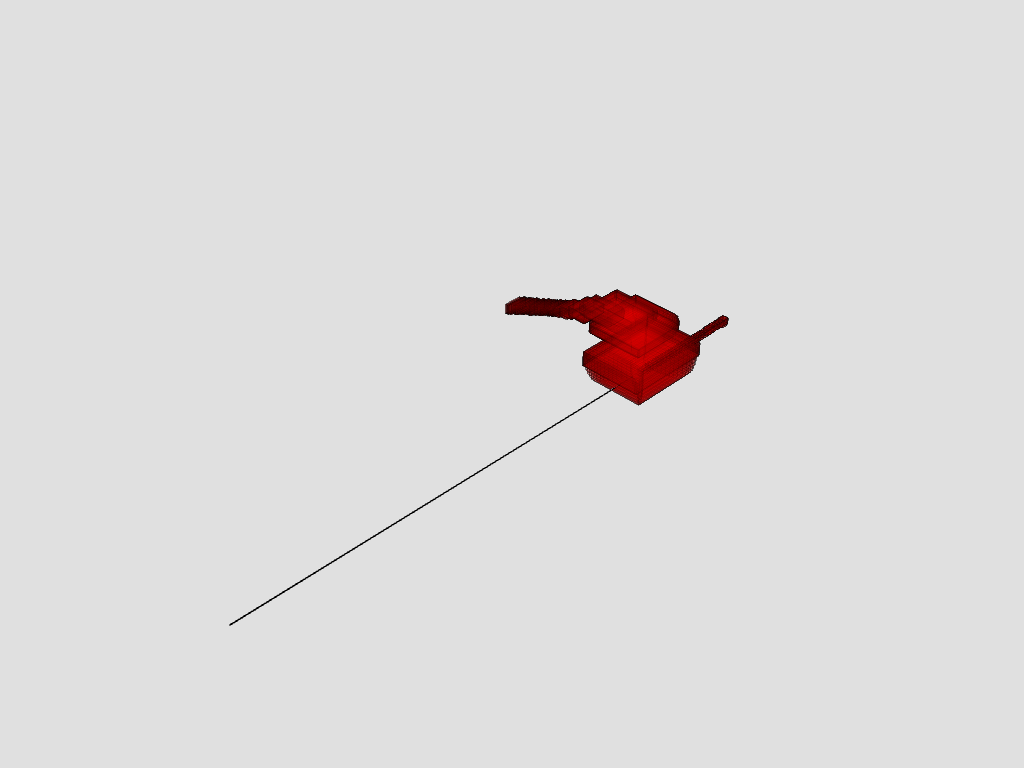

In [10]:
from verse.plotter.plotter3D import *
import pyvista as pv
import warnings
warnings.filterwarnings("ignore")

pv.set_jupyter_backend(None)
fig = pv.Plotter()
fig = plot3dMap(map1, ax=fig)
fig = plot3dReachtube(traces_veri, 'drone1', 1, 2, 3, color = 'r', ax=fig)
fig.set_background('#e0e0e0')
fig.show()
    

# 2. Adding multiple agents

In the previous section, we played around with a scenario with a single drone. In this example, we will create a scenario with multiple agents and explore the potential of Verse to handle multi-agent scenarios. 

In this example, we will look at a two drone collision avoidance example. In this example, we have two drones running in a map with three parallel tracks arranged in vertical directions. The two drones are running in the same direction on the middle track. However, the later drone is moving faster than the drone in the front and it will perform a track switch while getting close to the front drone to avoid collision. 

We will first setup a new scenario and add the map.

In [11]:
from verse.scenario import Scenario
from tutorial_map import M4
scenario = Scenario()
scenario.set_map(M4())

In [12]:
from enum import Enum, auto

class CraftMode(Enum):
    Normal = auto()
    MoveUp = auto()
    MoveDown = auto()

class TrackMode(Enum):
    T0 = auto()
    T1 = auto()
    T2 = auto()
    M01 = auto()
    M10 = auto()
    M12 = auto()
    M21 = auto()

class State:
    x: float
    y: float
    z: float
    vx: float
    vy: float
    vz: float
    craft_mode: CraftMode
    track_mode: TrackMode

    def __init__(self, x, y, z, vx, vy, vz, craft_mode, track_mode):
        pass

Verse's decision logic support python <code>any</code> and <code>all</code> functions, which allows the decision logic to quantify over other agents in the scenario. This enable user to easily create multi-agent scenario. In addition, the support of user defined functions, such as the <code>is_close</code> function in example, enable user to write more complicated decision logic. In this case, the decision logic will take an additional argument <code>others</code>, which provides the states for other agents. Notice the type hint for both <code>ego</code> and <code>others</code>. The updated agent's decision logic looks like following.

In [13]:
from typing import List
import copy

def is_close(ego, other):
    res = ((other.x - ego.x < 10 and other.x-ego.x > 8) or\
        (other.y-ego.y < 10 and other.y-ego.y > 8) or\
        (other.z-ego.z < 10 and other.z-ego.z > 8))
    return res

def decisionLogic(ego: State, others: List[State], track_map):
    next = copy.deepcopy(ego)

    if ego.craft_mode == CraftMode.Normal:
        if any(ego.x<other.x and (is_close(ego, other) and ego.track_mode == other.track_mode) for other in others):
            if track_map.h_exist(ego.track_mode, ego.craft_mode, CraftMode.MoveUp):
                next.craft_mode = CraftMode.MoveUp
                next.track_mode = track_map.h(
                    ego.track_mode, ego.craft_mode, CraftMode.MoveUp)
            if track_map.h_exist(ego.track_mode, ego.craft_mode, CraftMode.MoveDown):
                next.craft_mode = CraftMode.MoveDown
                next.track_mode = track_map.h(
                    ego.track_mode, ego.craft_mode, CraftMode.MoveDown)

    if ego.craft_mode == CraftMode.MoveUp:
        if track_map.altitude(ego.track_mode)-ego.z > -1 and track_map.altitude(ego.track_mode)-ego.z < 1:
            next.craft_mode = CraftMode.Normal
            if track_map.h_exist(ego.track_mode, ego.craft_mode, CraftMode.Normal):
                next.track_mode = track_map.h(
                    ego.track_mode, ego.craft_mode, CraftMode.Normal)

    if ego.craft_mode == CraftMode.MoveDown:
        if track_map.altitude(ego.track_mode)-ego.z > -1 and track_map.altitude(ego.track_mode)-ego.z < 1:
            next.craft_mode = CraftMode.Normal
            if track_map.h_exist(ego.track_mode, ego.craft_mode, CraftMode.Normal):
                next.track_mode = track_map.h(
                    ego.track_mode, ego.craft_mode, CraftMode.Normal)

    return next

With the updated decision logic, we can now spawn the two agents with their initial conditions. 

In [14]:
from tutorial_agent import DroneAgent
drone1 = DroneAgent(
    'drone1', file_name="dl_sec2.py", t_v_pair=(1, 1), box_side=[0.4]*3)
drone1.set_initial(
    [[1.5, -0.5, -0.5, 0, 0, 0], [2.5, 0.5, 0.5, 0, 0, 0]],
    (CraftMode.Normal, TrackMode.T1)
)

drone2 = DroneAgent(
    'drone2', file_name="dl_sec2.py", t_v_pair=(1, 0.5), box_side=[0.4]*3)
drone2.set_initial(
    [[19.5, -0.5, -0.5, 0, 0, 0], [20.5, 0.5, 0.5, 0, 0, 0]],
    (CraftMode.Normal, TrackMode.T1)
)

We can then add both agents to the scenario

In [15]:
scenario.add_agent(drone1)
scenario.add_agent(drone2)

With multiple agents in the scenario, we now need to add the sensor. The sensor defines how an agent is visible to other agents. In this example, we will use the default sensor function, which allows all agents to see all variables of other agents. 

In [16]:
from tutorial_sensor import DefaultSensor
scenario.set_sensor(DefaultSensor())

With the scenario fully constructed, we can now simulte or verify the scenario using the simulate/verify function provided by Verse. 

In [17]:
traces_simu = scenario.simulate(60, 0.2)
traces_veri = scenario.verify(60, 0.2)

[[1.6825174321992962, -0.23112221917642883, -0.16905295347763805, 0.0, 0.0, 0.0], [19.59295884037927, -0.04707565708038197, 0.35005604790014977, 0.0, 0.0, 0.0]]
{'drone1': ['Normal', 'T1'], 'drone2': ['Normal', 'T1']}
{'drone1': ('MoveDown', 'M12'), 'drone2': ['Normal', 'T1']}
{'drone1': ('MoveUp', 'M10'), 'drone2': ['Normal', 'T1']}
{'drone1': ('Normal', 'T2'), 'drone2': ['Normal', 'T1']}
{'drone1': ('Normal', 'T0'), 'drone2': ['Normal', 'T1']}


We can visualize the results using functions provided with Verse

ERROR:root:<<Cannot triangulate; no input points
ERROR:root:<<Cannot triangulate; no input points
ERROR:root:<<Cannot triangulate; no input points
ERROR:root:<<Cannot triangulate; no input points
ERROR:root:<<Cannot triangulate; no input points
ERROR:root:<<Cannot triangulate; no input points
ERROR:root:<<Cannot triangulate; no input points
ERROR:root:<<Cannot triangulate; no input points


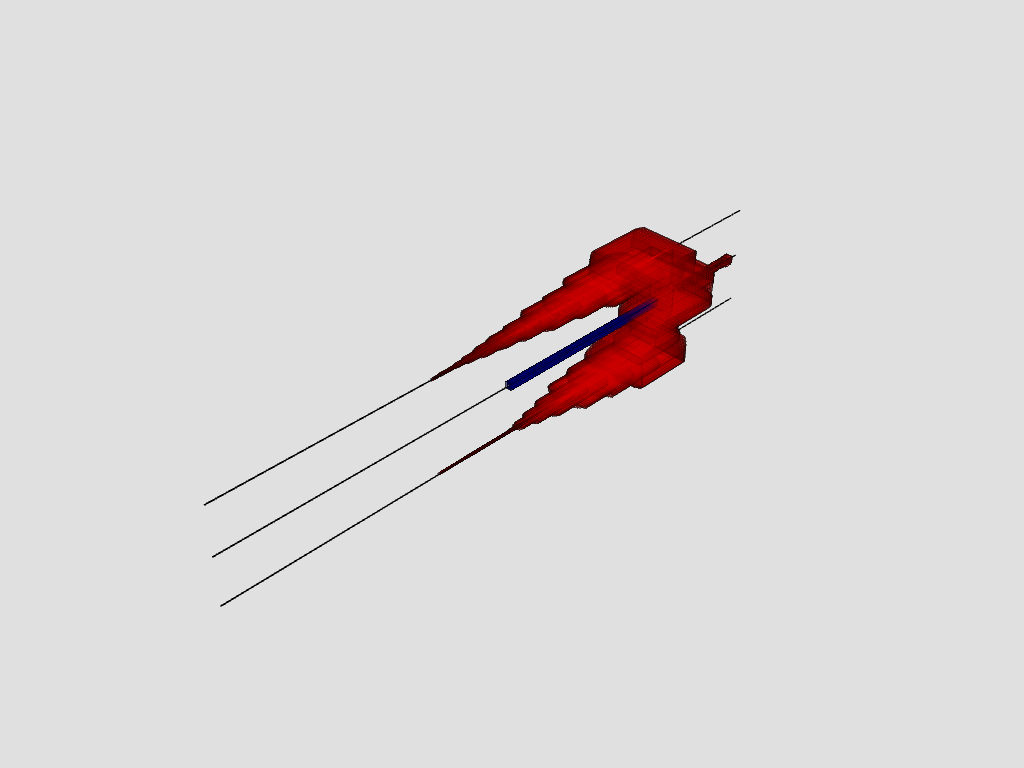

In [18]:
from verse.plotter.plotter3D import *
import pyvista as pv
import warnings
warnings.filterwarnings("ignore")

pv.set_jupyter_backend(None)
fig = pv.Plotter()
fig = plot3dMap(M4(), ax=fig)
fig = plot3dReachtube(traces_veri, 'drone1', 1, 2, 3, color = 'r', ax=fig)
fig = plot3dReachtube(traces_veri, 'drone2', 1, 2, 3, color = 'b', ax=fig)
fig.set_background('#e0e0e0')
fig.show()

# 3. Adding safety assertions

In [19]:
from enum import Enum, auto

class CraftMode(Enum):
    Normal = auto()
    MoveUp = auto()
    MoveDown = auto()

class TrackMode(Enum):
    T0 = auto()
    T1 = auto()
    T2 = auto()
    M01 = auto()
    M10 = auto()
    M12 = auto()
    M21 = auto()

class State:
    x: float
    y: float
    z: float
    vx: float
    vy: float
    vz: float
    craft_mode: CraftMode
    track_mode: TrackMode

    def __init__(self, x, y, z, vx, vy, vz, craft_mode, track_mode):
        pass

Verse allow checking safety conditions while performing simulation and verification. The safety conditions in verse can be specified using Python assert statements in the decision logic. With the <code>any</code> and <code>all</code> functions, the user can also define safety conditions between different agents. In this example, we are going to add two safety conditions: 1) the distance between two agents in all x,y,z direction should always be greater than or equal to 1.0m and 2) both drones should never enter region $40\leq x\leq 50$, $-5\leq y\leq 5$, $-10\leq z\leq -6$. The two safety asserts in the <code>decisionLogic</code> is shown below. 

In [20]:
from typing import List
import copy

def decisionLogic(ego: State, others: List[State], track_map):
    next = copy.deepcopy(ego)
    '''
    '''

    assert not any(ego.x-other.x < 1 and ego.x-other.x >-1 and \
        ego.y-other.y < 1 and ego.y-other.y > -1 and \
        ego.z-other.z < 1 and ego.z-other.z > -1 \
        for other in others),\
        "Safe Seperation"

    assert not (ego.x > 40 and ego.x<50 and\
        ego.y>-5 and ego.y<5 and\
        ego.z > -10 and ego.z<-6),\
        "Unsafe Region"

    return next

We can then construct the two agents and the scenario exactly as previous section.

In [21]:
from verse.scenario import Scenario
from tutorial_map import M4
scenario = Scenario()
scenario.set_map(M4())

from tutorial_agent import DroneAgent
drone1 = DroneAgent(
    'drone1', file_name="dl_sec3.py", t_v_pair=(1, 1), box_side=[0.4]*3)
drone1.set_initial(
    [[1.5, -0.5, -0.5, 0, 0, 0], [2.5, 0.5, 0.5, 0, 0, 0]],
    (CraftMode.Normal, TrackMode.T1)
)
scenario.add_agent(drone1)

drone2 = DroneAgent(
    'drone2', file_name="dl_sec3.py", t_v_pair=(1, 0.5), box_side=[0.4]*3)
drone2.set_initial(
    [[19.5, -0.5, -0.5, 0, 0, 0], [20.5, 0.5, 0.5, 0, 0, 0]],
    (CraftMode.Normal, TrackMode.T1)
)
scenario.add_agent(drone2)

from tutorial_sensor import DefaultSensor
scenario.set_sensor(DefaultSensor())

We can then simulate and verify the scenario and visualize the result. We can see from the result that drone1 enters the unsafe region, which causes a safety condition violation.

In [22]:
traces_simu = scenario.simulate(60, 0.2)
traces_veri = scenario.verify(60, 0.2)

[[1.6722128061640014, 0.09995783924441237, 0.16900501732746998, 0.0, 0.0, 0.0], [19.707369056178646, -0.241289877737354, 0.35297493504995214, 0.0, 0.0, 0.0]]
assert hit for drone1: "Unsafe Region" @ {'ego': State(x=40.000199779636084, y=-0.037841766053622106, z=-7.950996905640001, vx=0.9842831331582738, vy=-0.1968566266316516, vz=-0.40000000000001634, craft_mode='Normal', track_mode='T2'), 'others': [State(x=40.31825632534582, y=-0.024747705807999676, z=0.07297576509901882, vx=0.19685662663165115, vy=0.1968566266316525, vz=-0.400000000000007, craft_mode='Normal', track_mode='T1')], 'track_map': <tutorial_map.M4 object at 0x0000014723E39100>}
{'drone1': ['Normal', 'T1'], 'drone2': ['Normal', 'T1']}
{'drone1': ('MoveDown', 'M12'), 'drone2': ['Normal', 'T1']}
{'drone1': ('MoveUp', 'M10'), 'drone2': ['Normal', 'T1']}
{'drone1': ('Normal', 'T2'), 'drone2': ['Normal', 'T1']}
assert hit for drone1: "Unsafe Region"
69
{'drone1': ('Normal', 'T0'), 'drone2': ['Normal', 'T1']}


ERROR:root:<<Cannot triangulate; no input points
ERROR:root:<<Cannot triangulate; no input points
ERROR:root:<<Cannot triangulate; no input points
ERROR:root:<<Cannot triangulate; no input points
ERROR:root:<<Cannot triangulate; no input points
ERROR:root:<<Cannot triangulate; no input points
ERROR:root:<<Cannot triangulate; no input points


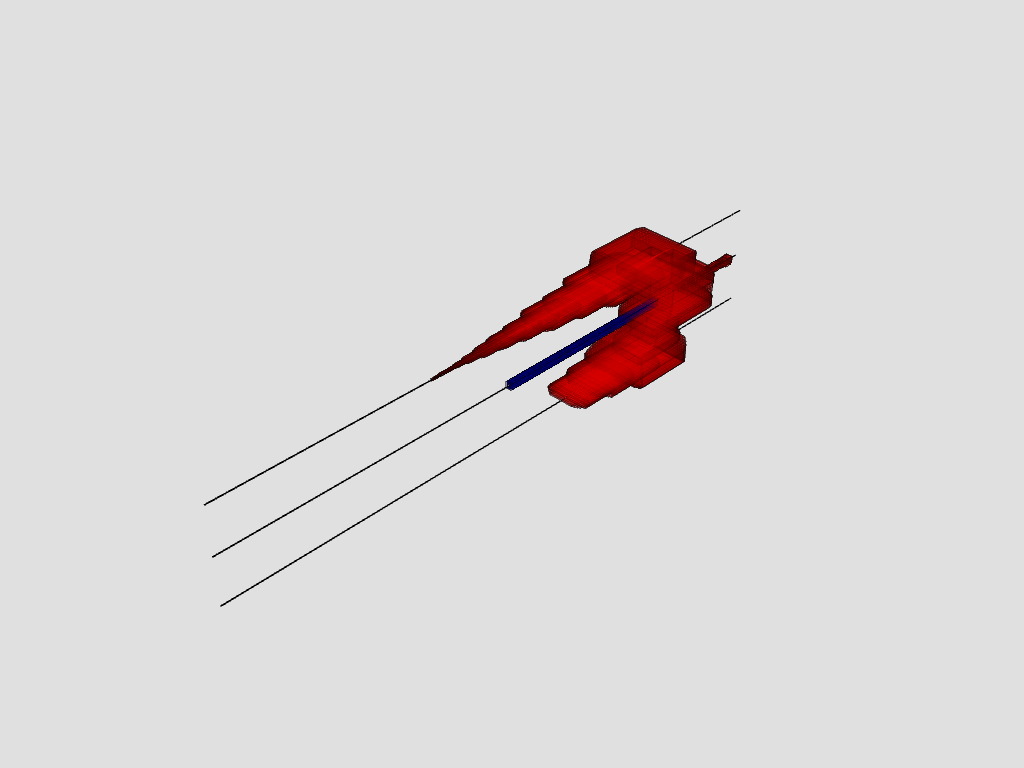

In [23]:
from verse.plotter.plotter3D import *
import pyvista as pv
import warnings
warnings.filterwarnings("ignore")

pv.set_jupyter_backend(None)
fig = pv.Plotter()
fig = plot3dMap(M4(), ax=fig)
fig = plot3dReachtube(traces_veri, 'drone1', 1, 2, 3, color = 'r', ax=fig)
fig = plot3dReachtube(traces_veri, 'drone2', 1, 2, 3, color = 'b', ax=fig)
fig.set_background('#e0e0e0')
fig.show()

# 4. Creating agent flow function (work in progress)

In previous sections, we discussed about how to create the decision logic for agents in Verse, in section we will look into detail about how the agent flows are specified and how the pieces are combined together for an agent in Verse. 

In this example, we will look at a simple kinetic bicycle model. The dynamics equations of the car are given by 
$$\dot{x} = v cos(\theta)$$
$$\dot{y} = v sin(\theta)$$
$$\dot{\theta} = \frac{v}{L}*tan(\delta)$$
$$\dot{v} = a$$
which are implemented as in the <code>car_dynamics</code> function below

In [24]:
import numpy as np
def car_dynamics(t, state, u):
    x, y, theta, v = state
    delta, a = u  
    x_dot = v*np.cos(theta+delta)
    y_dot = v*np.sin(theta+delta)
    theta_dot = v/1.75*np.tan(delta)
    v_dot = a 
    return [x_dot, y_dot, theta_dot, v_dot]

The flow function define the continuous time evolution of agents' continuous states. It takes as input the initial states of the agent and the a time, and outputs the state of the agent from that initial states at that time. In Verse, the flow function is implemented by the <code>TC_simulate</code> function in the agent class. The <code>TC_simulate</code> takes as input a mode, a initial continuous states, a time bound, a simulation time step and the map. It will output simulation of agent dynamics at given mode starting from the initial continuous states, until the time bound with time step as an np array. Below shows an implementation of the <code>TC_simulate</code> function for the car agent. Note some detail helper functions for the car dynamics placed in <code>tutorial_utils</code> are not shown explicitly in the example below. 

In [25]:
from tutorial_utils import car_action_handler
from typing import List 
import numpy as np 
from scipy.integrate import ode

def TC_simulate(mode: List[str], initialCondition, time_bound, time_step, track_map=None)->np.ndarray:
    time_bound = float(time_bound)
    number_points = int(np.ceil(time_bound/time_step))
    t = [round(i*time_step,10) for i in range(0,number_points)]

    init = initialCondition
    trace = [[0]+init]
    for i in range(len(t)):
        steering, a = car_action_handler(mode, init, track_map)
        r = ode(car_dynamics)    
        r.set_initial_value(init).set_f_params([steering, a])      
        res:np.ndarray = r.integrate(r.t + time_step)
        init = res.flatten().tolist()
        trace.append([t[i] + time_step] + init) 

    return np.array(trace)


With the <code>TC_simulate</code> function specified, we can now combine all parts together to construct a new car agent. An agent class for Verse should have four attributes: 1) <code>id</code>: an unique identifier for each agent in a scenario, 2) <code>controller</code>: a <code>ControllerIR</code> object, which is an intermediate representation of decisionLogic in Verse. It can be constructed automatically by passing in the decision logic code strings described in previous sections, 3) <code>TC_simulate</code> function, and 4) functions for setting initial condition of the agent, which can be inherited from <code>BaseAgent</code> class. 

In [26]:
from verse.parser.parser import ControllerIR
from verse.agents import BaseAgent

class CarAgent(BaseAgent):
    def __init__(self, id, code = None, file_name = None):
        self.id = id 
        self.decision_logic = ControllerIR.parse(code, file_name)
        self.TC_simulate = TC_simulate

We are going to test this CarAgent in a two car scenario with simple braking decision logic in an one track map. We can setup the scenario in Verse as we discussed in the previous section and simulate/verify the scenario. The results are visualized below. 

In [27]:
from enum import Enum, auto

class AgentMode(Enum):
    Normal = auto()
    Brake = auto()

class TrackMode(Enum):
    T0 = auto()

from verse.scenario import Scenario
from tutorial_map import M1
scenario = Scenario()
scenario.set_map(M1())


car1 = CarAgent('car1', file_name="dl_sec4.py")
car1.set_initial([[0,-0.5,0,2],[1,0.5,0,2]], (AgentMode.Normal, TrackMode.T0))
car2 = CarAgent('car2', file_name="dl_sec4.py")
car2.set_initial([[15,-0.5,0,1],[16,0.5,0,1]], (AgentMode.Normal, TrackMode.T0))
scenario.add_agent(car1)
scenario.add_agent(car2)

traces_simu = scenario.simulate(10, 0.01)
traces_veri = scenario.verify(10, 0.01)

import plotly.graph_objects as go
from verse.plotter.plotter2D import *

fig = go.Figure()
fig = simulation_tree(traces_simu, None, fig, 0, 1, [0, 1], 'lines', 'trace')
fig.show()

fig = go.Figure()
fig = reachtube_tree(traces_veri, None, fig, 0, 1, [0, 1], 'lines', 'trace')
fig.show()

[[0.4057053291279925, 0.038235232846809075, 0.0, 2.0], [15.261042602504604, 0.09586612952644313, 0.0, 1.0]]
{'car1': ['Normal', 'T0'], 'car2': ['Normal', 'T0']}
{'car1': ('Brake', 'T0'), 'car2': ['Normal', 'T0']}


# 5. Creating map (work in progress)

In this section, we will look at how to create a map for Verse by extending the map we used in the previous section from 1 lane to 2 lanes. 

The map will contain a set of tracks, that the agent's continuous dynamics roughly follows. In addition, we also assume that an agent's decision logic does not depend on exactly which of the infinitely many tracks it is following, but instead, it depends only on which type of track it is following, or the track mode. In this example, as shown in the figure below, each of the lanes will have a track mode <code>T0</code> and <code>T1</code>. In Verse, we can create the two types of tracks <code>T0</code> and <code>T1</code> using the <code>Lane</code> object, with each of them having one straight segment constructed by <code>StraightLane</code> as shown below. 


In [28]:
from verse.map.lane_segment import StraightLane
from verse.map.lane import Lane

segment0 = StraightLane('seg0', [0,0], [500,0], 3)
lane0 = Lane('T0', [segment0])
segment1 = StraightLane('seg1', [0,3], [500,3], 3)
lane1 = Lane('T1', [segment1])

Verse currently implments <code>StraightLane</code> and <code>CircularLane</code>, which corresponding to straight line and circular curves. In addition, we allow each <code>Lane</code> to have multiple concatenated <code>StraightLane</code> or <code>CircularLane</code>.

In addition, we also define the transition between tracks. For example, every track for transitioning from point on <code>T0</code> to a corresponding point on <code>T1</code> has track mode <code>M01</code>. Therefore, in this example, our map will have a total of 4 track modes <code>T0</code>, <code>T1</code>, <code>M01</code>, and <code>M10</code>. 

![map_2lanes_lab](map_2lanes_lab.png)


The map will have a mapping function <code>g</code>, which can provide the track that the agent is following given a track mode and the agent's current position. In this example, we can inherit the g function from the base class <code>LaneMap</code>

Finally, a Verse agent's decision logic can change its interal or tactical mode (E.g. <code>Normal</code> to <code>SwitchLeft</code>). When an agent changes its tactical mode, it may also update the track it's following and this is encoded in another function <code>h</code>, which takes the current track mode, the current and the next tactical mode, and generates the new track mode the agent should follow. In this example, the agents have tacical mode <code>Normal</code>, <code>SwitchLeft</code> and <code>SwitchRight</code>. Therefore, an example <code>h</code> function looks like following. 

In [29]:
h_dict = {
    ('T0','Normal','SwitchLeft'): 'M01',
    ('T1','Normal','SwitchRight'): 'M10',
    ('M01','SwitchLeft','Normal'): 'T1',
    ('M10','SwitchRight','Normal'): 'T0',
}

def h(lane_idx, agent_mode_src, agent_mode_dest):
    return h_dict[(lane_idx, agent_mode_src, agent_mode_dest)]

def h_exist(lane_idx, agent_mode_src, agent_mode_dest):
    return (lane_idx, agent_mode_src, agent_mode_dest) in h_dict

With all these pieces, we can now create the map for this scenario.

In [30]:
from verse.map import LaneMap 

class Map2Lanes(LaneMap):
    def __init__(self):
        super().__init__()
        self.add_lanes([lane0, lane1])
        self.h = h 
        self.h_exist = h_exist 

In [33]:
from enum import Enum, auto

class AgentMode(Enum):
    Normal = auto()
    SwitchLeft = auto()
    SwitchRight = auto()

class TrackMode(Enum):
    T0 = auto()
    T1 = auto()
    M01 = auto()
    M10 = auto()

from verse.scenario import Scenario
scenario = Scenario()
scenario.set_map(Map2Lanes())

from tutorial_agent import CarAgent
car1 = CarAgent('car1', file_name="dl_sec5.py")
car1.set_initial([[0,-0.5,0,2],[1,0.5,0,2]], (AgentMode.Normal, TrackMode.T0))
car2 = CarAgent('car2', file_name="dl_sec5.py")
car2.set_initial([[20,-0.5,0,1],[21,0.5,0,1]], (AgentMode.Normal, TrackMode.T0))
scenario.add_agent(car1)
scenario.add_agent(car2)

traces_simu = scenario.simulate(20, 0.01)
# traces_veri = scenario.verify(20, 0.01)

import plotly.graph_objects as go
from verse.plotter.plotter2D import *

fig = go.Figure()
fig = simulation_tree(traces_simu, Map2Lanes(), fig, 1, 2, [1, 2], 'lines', 'trace')
fig.show()

# fig = go.Figure()
# fig = reachtube_tree(traces_veri, Map2Lanes(), fig, 1, 2, [1, 2], 'lines', 'trace')
# fig.show()

[[0.725480016432595, -0.015957073368145114, 0.0, 2.0], [20.18512118584031, 0.01170975777666039, 0.0, 1.0]]
